In [ ]:
from pyspark.sql import functions as F
from _global_vars import *
import seaborn as sns
import numpy as np

In [2]:
# read in sdf
sdf = spark.read.parquet('../data/curated/yt2019_feature_eng.parquet')
#sdf.show(1, vertical=True, truncate=100)

**Note:** *a subsample is taken heterogeneously for visualisations due to the large size of the dataset*

In [10]:
# sub sample of (0.025%) approx. 850k records
print(f"Before subsampling size: {sdf.count()}")
sdf_sub = sdf.sample(fraction=0.01, seed=0) #TODO Check this
print(f"After subsampling size: {sdf_sub.count()}")

840097

In [ ]:
# convert to pandas dataframe
df_sub = sdf_sub.toPandas()

---
#### Univariate Analysis of Features
---

**Passenger count**

In [12]:
# numerically
sdf.groupBy("passenger_count").count().sort("passenger_count").show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|           null|  440996|
|            0.0| 1518289|
|            1.0|58821100|
|            2.0|12721013|
|            3.0| 3565925|
|            4.0| 1700234|
|            5.0| 3382896|
|            6.0| 2029534|
|            7.0|     416|
|            8.0|     276|
|            9.0|     224|
+---------------+--------+



<AxesSubplot:xlabel='passenger_count', ylabel='count'>

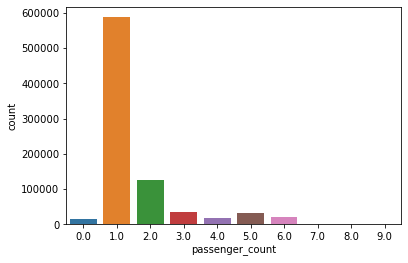

In [13]:
# visually
sns.countplot(x=df_sub['passenger_count'])

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

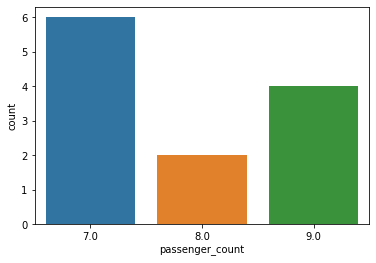

In [14]:
# take a peak at the extreme values
p_count_out_of_range = df_sub[df_sub['passenger_count'] > 6]
sns.countplot(x=p_count_out_of_range['passenger_count'])

Findings:
* Passenger count has values up to 9.
* Should be limited between 1-6. According to TLC guidelines
* Higher values for 9 passengers than for that of 8
* Suggesting the taxi driver might occasionally just enter the highest number?

Upshot:
* Restrict range of passenger_count (1:6) [drop other records]

**Trip distance**

In [15]:
# peak at negative tail values
sdf.groupBy("trip_distance").count().sort("trip_distance").show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|    -37264.53|    1|
|    -18739.24|    1|
|       -34.94|    1|
|       -34.67|    1|
|       -34.44|    1|
|       -33.51|    1|
|       -32.96|    1|
|       -32.61|    1|
|        -31.9|    1|
|       -31.76|    1|
|       -31.18|    1|
|       -30.86|    1|
|       -30.61|    1|
|       -30.52|    1|
|        -30.5|    1|
|       -30.14|    1|
|        -30.1|    1|
|       -30.05|    1|
|       -29.91|    1|
|       -29.82|    2|
+-------------+-----+
only showing top 20 rows



In [16]:
# peak at positive tail values
sdf.groupBy("trip_distance").count().sort(F.desc("trip_distance")).show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|     45977.22|    1|
|     19130.18|    1|
|        831.8|    1|
|        830.9|    1|
|        701.5|    1|
|        701.3|    1|
|        700.7|    1|
|        603.5|    1|
|        601.6|    1|
|       543.09|    1|
|        401.4|    1|
|       363.13|    1|
|       323.81|    1|
|       311.56|    1|
|       307.95|    1|
|        307.5|    1|
|        306.9|    1|
|        300.8|    1|
|       294.07|    1|
|       263.21|    1|
+-------------+-----+
only showing top 20 rows



In [17]:
# some serious distances being covered
sdf.sort(F.desc("trip_distance")).limit(5)

hour_of_day_of_year,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,congestion_surcharge,PU_datetime,DO_datetime,PU_hourofday,DO_hourofday,PU_dayofweek,DO_dayofweek,PU_dayofmonth,DO_dayofmonth,PU_month,DO_month,trip_time_minutes,trip_speed_mph,fare_per_minute,tmpf,dwpf,relh
2019-06-14 10:00:00,2,2019-06-14 10:53:40,2019-06-14 10:54:57,1.0,45977.22,4,193,193,2,0.0,0.0,0.0,2019-06-14,2019-06-14,10,10,6,14,14,14,6,6,1.2833333333333334,2149584.3116883114,0.0,57.9,54.0,86.82
2019-12-04 10:00:00,2,2019-12-04 10:20:13,2019-12-04 10:24:43,1.0,19130.18,5,224,224,2,11.0,0.0,0.0,2019-12-04,2019-12-04,10,10,4,4,4,4,12,12,4.5,255069.06666666668,2.4444444444444446,35.1,27.0,72.04
2019-01-25 21:00:00,1,2019-01-25 21:56:39,2019-01-25 22:06:08,1.0,831.8,1,140,239,1,8.5,1.96,0.0,2019-01-25,2019-01-25,21,22,6,25,25,25,1,1,9.483333333333333,5262.706502636204,0.8963093145869948,35.1,6.1,29.12
2019-04-27 23:00:00,1,2019-04-27 23:42:13,2019-04-27 23:49:48,1.0,830.9,1,234,186,1,7.0,2.15,2.5,2019-04-27,2019-04-27,23,23,7,27,27,27,4,4,7.583333333333333,6574.153846153847,0.9230769230769231,53.1,30.9,42.48
2019-02-01 15:00:00,1,2019-02-01 15:53:09,2019-02-01 16:06:15,1.0,701.5,1,114,249,1,10.0,2.7,0.0,2019-02-01,2019-02-01,15,16,6,1,1,1,2,2,13.1,3212.977099236641,0.7633587786259542,15.1,-8.0,34.44
2019-11-15 19:00:00,1,2019-11-15 19:37:19,2019-11-15 19:50:08,3.0,701.3,1,68,163,2,9.5,0.0,2.5,2019-11-15,2019-11-15,19,19,6,15,15,15,11,11,12.816666666666666,3283.0689206762027,0.7412223667100131,50.0,21.0,31.6
2019-01-18 16:00:00,1,2019-01-18 16:32:24,2019-01-18 16:39:20,1.0,700.7,1,236,262,1,6.0,1.2,null,2019-01-18,2019-01-18,16,16,6,18,18,18,1,1,6.933333333333334,6063.75,0.8653846153846153,36.666666666666664,32.0,83.03000000000002
2019-09-16 07:00:00,1,2019-09-16 07:40:26,2019-09-16 07:58:57,3.0,603.5,1,33,113,1,15.5,3.76,2.5,2019-09-16,2019-09-16,7,7,2,16,16,16,9,9,18.516666666666666,1955.5355535553556,0.8370837083708371,72.0,57.0,59.2
2019-08-06 21:00:00,1,2019-08-06 21:26:36,2019-08-06 21:34:23,0.0,601.6,1,170,141,1,7.5,2.25,2.5,2019-08-06,2019-08-06,21,21,3,6,6,6,8,8,7.783333333333333,4637.601713062099,0.9635974304068523,78.1,68.0,71.14
2019-11-19 04:00:00,2,2019-11-19 04:32:39,2019-11-19 10:13:46,5.0,543.09,5,132,264,2,400.0,0.0,0.0,2019-11-19,2019-11-19,4,10,3,19,19,19,11,11,341.1166666666667,95.52567547759809,1.1726193384472565,41.0,39.0,92.52


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

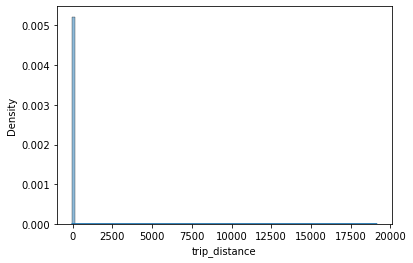

In [18]:
sns.histplot(x=df_sub['trip_distance'], bins=100, kde=True, stat='density')

In [ ]:
# perform log transformation to help visualise
sns.histplot(x=np.log(df_sub['trip_distance']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_distance'>

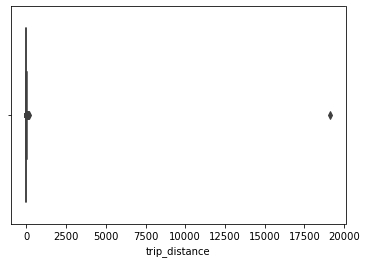

In [20]:
sns.boxplot(x=df_sub['trip_distance'])

Findings:
* Looks extremely right skewed
* Divide by zero error thrown => we have non strictly positive trip distances
* Extremely long trip distances => -33,000 kms! not representative in sample tho
* Most positive distances seem reasonable, worthy of further inspection
* Contains negative distances
* Contains extremely large distances

Upshot:
* Log transformation might be useful when intending to model
* Restrict to entries with: 0 < trip distance < 312km

>312km is chosen as it bounds all relevant taxi zones

**Fare amount**

In [21]:
# inspect positive tail
sdf.groupBy("fare_amount").count().sort(F.desc("fare_amount")).show()

+-----------+-----+
|fare_amount|count|
+-----------+-----+
|   943274.8|    1|
|  671123.14|    1|
|  623259.86|    1|
|  411042.01|    1|
|  398468.38|    1|
|  395839.94|    1|
|  355676.98|    1|
|  346949.99|    1|
|  171862.12|    1|
|  150998.39|    1|
|   147639.5|    1|
|    90000.0|    1|
|    36090.3|    1|
|   34674.65|    1|
|   33023.53|    1|
|   31107.91|    1|
|   30444.52|    1|
|   30130.71|    1|
|   25628.96|    1|
|   25356.38|    1|
+-----------+-----+
only showing top 20 rows



In [22]:
# inspect negative tail
sdf.groupBy("fare_amount").count().sort("fare_amount").show()

+-----------+-----+
|fare_amount|count|
+-----------+-----+
|    -1856.0|    1|
|    -1472.0|    1|
|     -600.0|    1|
|     -530.0|    1|
|     -500.0|    1|
|     -498.0|    1|
|     -497.0|    1|
|     -483.0|    1|
|    -450.08|    1|
|     -450.0|    2|
|     -447.0|    1|
|     -442.0|    1|
|     -422.0|    2|
|     -400.0|    7|
|     -395.0|    1|
|     -375.0|    3|
|     -362.0|    1|
|     -360.0|    2|
|     -350.0|    3|
|     -340.0|    1|
+-----------+-----+
only showing top 20 rows



<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

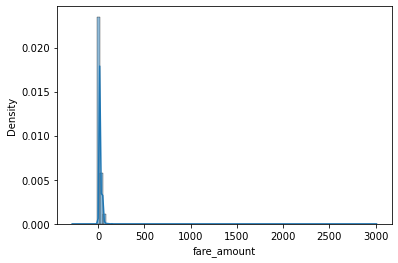

In [23]:
sns.histplot(x=df_sub['fare_amount'], bins=100, kde=True, stat='density')

In [ ]:
# perform log transformation to help visualise right skew
sns.histplot(x=np.log(df_sub['fare_amount']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='fare_amount'>

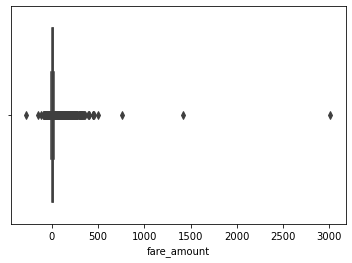

In [25]:
sns.boxplot(x=df_sub['fare_amount'])

In [ ]:
# inspect fares above 2.50 (USD)
capped_fare_amnt = df_sub[df_sub['fare_amount'] > 2.5]

<AxesSubplot:xlabel='fare_amount'>

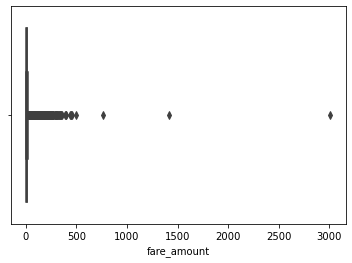

In [27]:
sns.boxplot(x=capped_fare_amnt['fare_amount'])

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

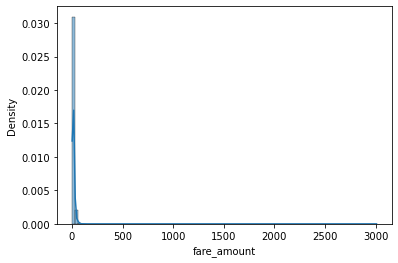

In [28]:
sns.histplot(x=capped_fare_amnt['fare_amount'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

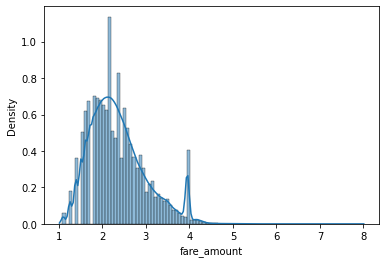

In [29]:
sns.histplot(x=np.log(capped_fare_amnt['fare_amount']), bins=100, kde=True, stat='density')

Findings:
* Fare amount contains zero values
* Right skewed
* Extremely high fare values in full dataset
* Extremely negative fare values in full dataset
* Fare values shows banding when looking at the subsample
* Peaks at fare amounts of around log(4): could be airport or hotspot etc

Upshot:
* Take log
* Restrict values between 1.5*IQR
* Fares capped at $500

**Trip speed (mph)**

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

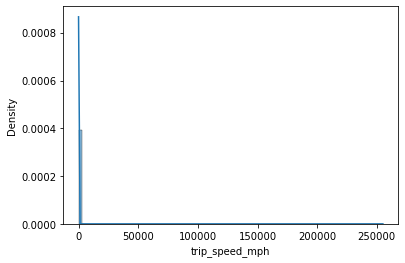

In [30]:
sns.histplot(x=df_sub['trip_speed_mph'], bins=100, kde=True, stat='density')

In [ ]:
sns.histplot(x=np.log(df_sub['trip_speed_mph']), bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_speed_mph'>

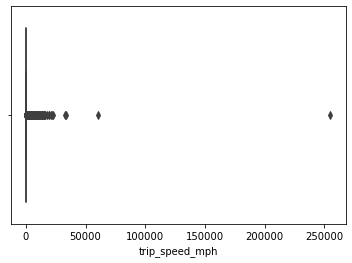

In [32]:
sns.boxplot(x=df_sub['trip_speed_mph'])

In [33]:
# investigate distribution with restrictions; speeds between 1 and 65 mph
capped_speed = df_sub[(df_sub['trip_speed_mph'] <= 65) & (df_sub['trip_speed_mph'] > 1)]

<AxesSubplot:xlabel='trip_speed_mph'>

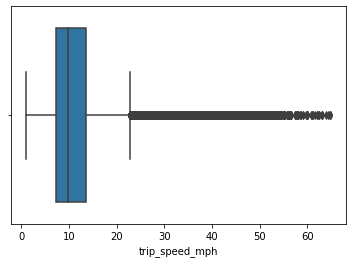

In [34]:
 sns.boxplot(x=capped_speed['trip_speed_mph'])

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

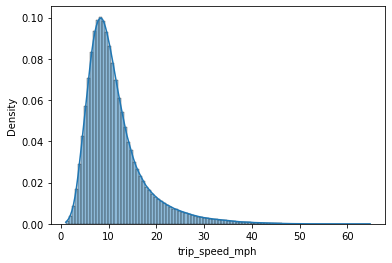

In [35]:
# right skewed again
sns.histplot(x=capped_speed['trip_speed_mph'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_speed_mph', ylabel='Density'>

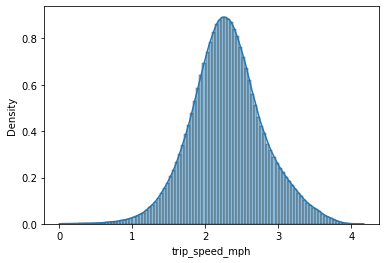

In [36]:
# doesn't that look nice?
sns.histplot(x=np.log(capped_speed['trip_speed_mph']), bins=100, kde=True, stat='density')

Findings:
* Extreme speeds.
* NYC speed limit is 65 mph at the most on the highways, most of it should be less than that if it is taking place in NYC
* Trips that had a speed of less than 1 mph?

Implements:
* remove trips with average speed over 65 mph
* remove trips less than 1 mph


**Trip Duration** (expected to be highly correlated with trip speed)

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

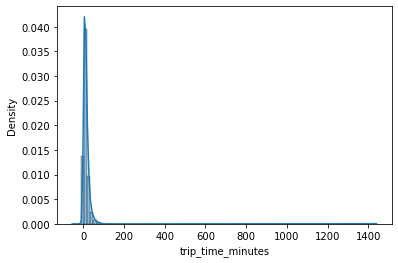

In [37]:
sns.histplot(x=df_sub['trip_time_minutes'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_time_minutes'>

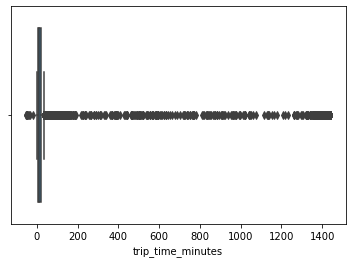

In [38]:
sns.boxplot(x=df_sub['trip_time_minutes'])

In [ ]:
sns.histplot(x=np.log(df_sub['trip_time_minutes']), bins=100, kde=True, stat='density')

In [40]:
# investigate distribution with restrictions;
# -> trip times less than 8 hours and longer than 2 minutes
capped_time = df_sub[(df_sub['trip_time_minutes'] <= 480) & (df_sub['trip_time_minutes'] > 2)]

<AxesSubplot:xlabel='trip_time_minutes'>

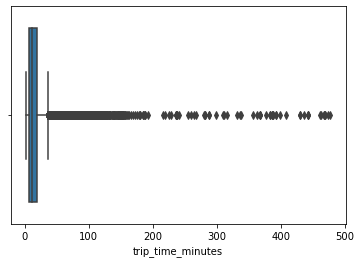

In [41]:
sns.boxplot(x=capped_time['trip_time_minutes'])

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

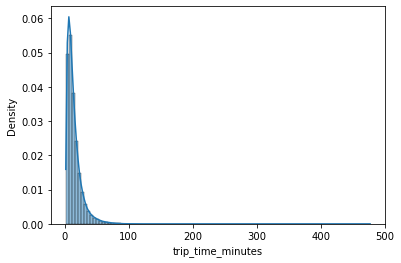

In [42]:
# right skewed again, again
sns.histplot(x=capped_time['trip_time_minutes'], bins=100, kde=True, stat='density')

<AxesSubplot:xlabel='trip_time_minutes', ylabel='Density'>

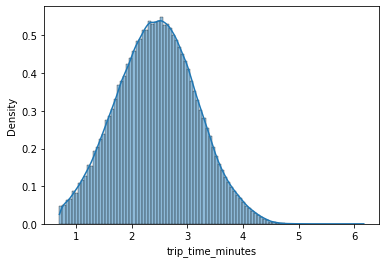

In [43]:
# much more gaussian
sns.histplot(x=np.log(capped_time['trip_time_minutes']), bins=100, kde=True, stat='density')

Findings:
* Extremely long trip times up to 1400 minutes (just in the sample)

Upshot:
* Limit trip times to under 8 hours (480 minutes) (a whole shift, which would be a big ask for a taxi driver)
* Trips with a time of less than 2 minutes should be excluded as they are
    * Not very realistic
    * Or the passenger may have cancelled

---
### Date/Time Analysis
---

**Distribution of trips across time**
> Months of year

In [ ]:
month_counts = sdf.groupBy("PU_month").count()
month_counts_df = month_counts.toPandas()

    PU_month    count
0         12  6697922
1          1  7693187
2          6  6971335
3          3  7866400
4          5  7571377
5          9  6542493
6          4  7475959
7          8  6059977
8          7  6291619
9         10  7179886
10        11  6808156
11         2  7022592


<AxesSubplot:xlabel='PU_month', ylabel='count'>

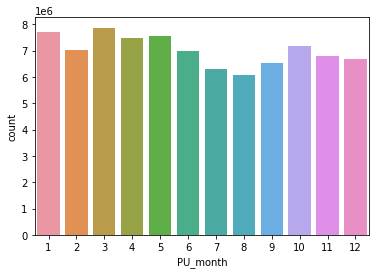

In [46]:
# numerically
print(month_counts_df)
# visually
sns.barplot(x=month_counts_df['PU_month'], y=month_counts_df['count'])

> Weeks of the year

In [47]:
PU_day_of_week_df = sdf.groupBy("PU_dayofweek").count().toPandas()

   PU_dayofweek     count
0             1  10427700
1             6  12926486
2             3  12220622
3             5  13010032
4             4  12608716
5             7  12064745
6             2  10922602


<AxesSubplot:xlabel='PU_dayofweek', ylabel='count'>

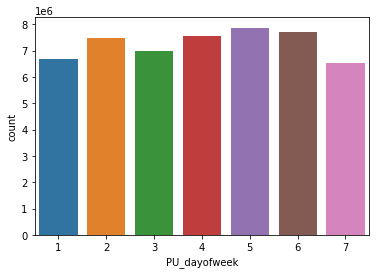

In [48]:
# numerically
print(PU_day_of_week_df)
# visually
sns.barplot(x=PU_day_of_week_df['PU_dayofweek'], y=month_counts_df['count'])

**Pickup Locations**

In [49]:
PU_LocationID_Counts = sdf.groupBy("PULocationID").count().toPandas()

     PULocationID    count
257           104        1
228           199       13
214           204       29
135           176       32
241            99       37
..            ...      ...
244           186  3014310
136           162  3034557
30            236  3274823
131           161  3437529
173           237  3624800

[263 rows x 2 columns]


<AxesSubplot:xlabel='PULocationID', ylabel='count'>

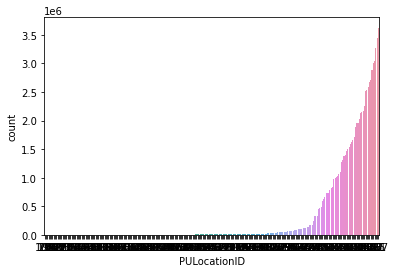

In [50]:
# Pickup day of week -> by count

print(PU_LocationID_Counts.sort_values('count'))
PULocationID_counts_sorted = PU_LocationID_Counts.sort_values('count')

sns.barplot(x=PULocationID_counts_sorted['PULocationID'], y=PULocationID_counts_sorted['count'], order=PULocationID_counts_sorted['PULocationID'])

<AxesSubplot:xlabel='PULocationID', ylabel='count'>

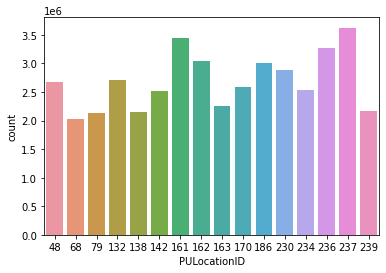

In [51]:
# peek at distribution of the highest frequency pickup locations
PULocationID_counts_top = PU_LocationID_Counts[PU_LocationID_Counts['count'] > 2000000]
sns.barplot(x=PULocationID_counts_top['PULocationID'], y=PULocationID_counts_top['count'])

**Pick Up Times**

In [52]:
PU_hourofday_counts = sdf.groupBy("PU_hourofday").count().toPandas()

<AxesSubplot:xlabel='PU_hourofday', ylabel='count'>

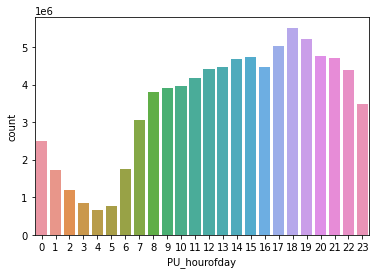

In [53]:
# Note; the timezones are off
sns.barplot(x=PU_hourofday_counts['PU_hourofday'], y=PU_hourofday_counts['count'])

**Congestion Surcharge**

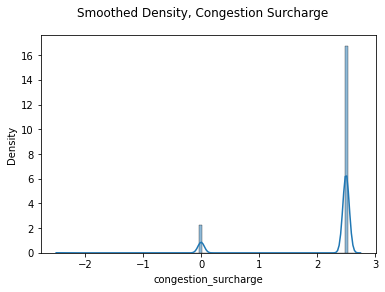

In [55]:
#df_sub['congestion_surcharge']
con_hist = sns.histplot(x=df_sub['congestion_surcharge'], bins=100, kde=True, stat='density')
fig = con_hist.get_figure()
fig.suptitle("Smoothed Density, Congestion Surcharge")
fig.savefig('../plots/congestion_surcharge_density.png')

<AxesSubplot:xlabel='congestion_surcharge'>

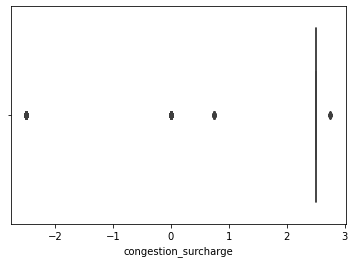

In [56]:
sns.boxplot(x=df_sub['congestion_surcharge'])

In [57]:
df_sub['congestion_surcharge'].sort_values(ascending=False)

820492    2.75
348785    2.75
177297    2.75
298134    2.75
616390    2.75
          ... 
840092     NaN
840093     NaN
840094     NaN
840095     NaN
840096     NaN
Name: congestion_surcharge, Length: 840097, dtype: float64

Findings:
* Congestion surcharge contains negative values
* Doesnt appear to go above $3
* has two peaks? for whatever reason

Upshot:
* Congestion surcharge capped at 10 usd -> any records beyond this can go away
* Range [0:10]

---
#### Categorical Variable Analysis #
---

**VendorID**

In [58]:
# numerically
sdf.groupBy("VendorID").count().sort("VendorID").show()
# visually
vendorid_groups = sdf.groupBy("VendorID").count().sort("VendorID").toPandas()
sns.barplot(x=vendorid_groups['VendorID'], y=vendorid_groups['count'])

+--------+--------+
|VendorID|   count|
+--------+--------+
|       1|30227904|
|       2|53685949|
|       4|  266775|
|       5|     275|
+--------+--------+



Visualisations not very useful due to large class imbalance
* Hence limit investigation to valid VendorID's

In [61]:
# limit vendorID
vendorid_groups_clean = vendorid_groups[(vendorid_groups['VendorID'] == 1) | (vendorid_groups['VendorID'] == 2)]
sns.barplot(x=vendorid_groups_clean['VendorID'], y=vendorid_groups_clean['count'])

Findings
* VendorID should be only 1,2
* Contains 4,5's
* VendorID 2 has a significant share of trips compared to VendorID 1

Upshot:
* Remove rows with incorrect VendorID -> limit range to (1:2)

**RatecodeID**

In [63]:
ratecodeid_ = sdf.groupBy("RatecodeID").count().sort("RatecodeID").toPandas()
ratecodeid_

<AxesSubplot:xlabel='RatecodeID', ylabel='count'>

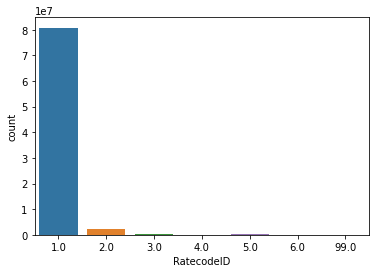

In [65]:
sns.barplot(x=ratecodeid_['RatecodeID'], y=ratecodeid_['count'])

Findings:
* Ratecode should be between 1-6 according to NYC TLC guidelines
* Contains 99? Could be due to driver just inputting 99 when they encounter an issue

Upshot:
* Limit ratecodeID entries between [1,6]
* Maybe only use standard rate ratecodes?

**Payment Type**

In [66]:
payment_type = sdf.groupBy("payment_type").count().sort("payment_type").toPandas()
payment_type

Findings:
* According to yellow taxi data dictionary: we are only interested in Credit Card (1) and Cash (2)

Upshot:
* Remove payment types != 1,2

In [68]:
spark.sql("CLEAR CACHE")
spark.stop()